# DATA PREPROCESSING

# Importing The Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importing The Dataset

In [2]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='DniKDOiBzjciVYi0lFC0XLbDwNMPgaL7RkoNT-y7NhQ2',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'crudeoilpricepredictionusinglstm-donotdelete-pr-cscxajvuz8ywfj'
object_key = 'Crude Oil Prices Daily.xlsx'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']

data = pd.read_excel(body.read())
data.head()

,Date,Closing Value
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87


# Handling Missing Values

In [3]:
data.isnull().any()

Date             False
Closing Value     True
dtype: bool

In [4]:
data.isnull().sum()

Date             0
Closing Value    7
dtype: int64

In [5]:
data.dropna(axis=0,inplace=True)
data.isnull().sum()

Date             0
Closing Value    0
dtype: int64

In [6]:
data_oil = data.reset_index()["Closing Value"]
data_oil

0       25.56
1       26.00
2       26.53
3       25.85
4       25.87
        ...  
8211    73.89
8212    74.19
8213    73.05
8214    73.78
8215    73.93
Name: Closing Value, Length: 8216, dtype: float64

# Feature Scaling

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler ( feature_range = (0,1) )
data_oil = scaler.fit_transform(np.array(data_oil).reshape(-1,1))

# Data Visualization

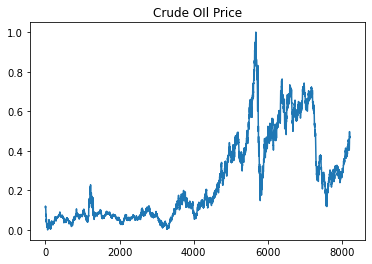

In [8]:
plt.title('Crude OIl Price')
plt.plot(data_oil)

# Splitting Data Into Train and Test

In [9]:
training_size = int(len(data_oil)*0.65)
test_size = len(data_oil)-training_size
train_data, test_data = data_oil[0:training_size,:], data_oil[training_size:len(data_oil),:1]

In [10]:
training_size, test_size

(5340, 2876)

In [11]:
train_data.shape

(5340, 1)

# Creating A Dataset With Sliding Windows

In [12]:
import numpy
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [13]:
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [14]:
print(X_train.shape), print(y_train.shape)

(5329, 10)
(5329,)


(None, None)

In [15]:
print(X_test.shape), print(ytest.shape)

(2865, 10)
(2865,)


(None, None)

In [16]:
X_train

array([[0.11335703, 0.11661484, 0.12053902, ..., 0.10980305, 0.1089886 ,
        0.11054346],
       [0.11661484, 0.12053902, 0.11550422, ..., 0.1089886 , 0.11054346,
        0.10165852],
       [0.12053902, 0.11550422, 0.1156523 , ..., 0.11054346, 0.10165852,
        0.09906708],
       ...,
       [0.36731823, 0.35176958, 0.36080261, ..., 0.36391234, 0.37042796,
        0.37042796],
       [0.35176958, 0.36080261, 0.35354657, ..., 0.37042796, 0.37042796,
        0.37879461],
       [0.36080261, 0.35354657, 0.35295424, ..., 0.37042796, 0.37879461,
        0.37916482]])

In [17]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

# MODEL BUILDING

# Importing The Model Building Libraries

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# Initializing The Model

In [19]:
model = Sequential()

# Adding LSTM Layers

In [20]:
model.add(LSTM(50,return_sequences = True, input_shape = (10,1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))

# Adding Output Layers

In [21]:
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


# Configure The Learning Process

In [22]:
model.compile(loss='mean_squared_error', optimizer = 'adam')

# Train The Model

In [23]:
model.fit(X_train, y_train, validation_data = (X_test, ytest), epochs = 10, batch_size = 64, verbose = 1)

Epoch 1/10
84/84 [==============================] - 5s 27ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 2/10
84/84 [==============================] - 1s 15ms/step - loss: 1.2813e-04 - val_loss: 7.7552e-04
Epoch 3/10
84/84 [==============================] - 2s 21ms/step - loss: 1.2164e-04 - val_loss: 7.6818e-04
Epoch 4/10
84/84 [==============================] - 2s 22ms/step - loss: 1.2296e-04 - val_loss: 0.0014
Epoch 5/10
84/84 [==============================] - 2s 22ms/step - loss: 1.4032e-04 - val_loss: 7.7493e-04
Epoch 6/10
84/84 [==============================] - 2s 20ms/step - loss: 1.2410e-04 - val_loss: 9.9714e-04
Epoch 7/10
84/84 [==============================] - 2s 22ms/step - loss: 1.1979e-04 - val_loss: 9.8937e-04
Epoch 8/10
84/84 [==============================] - 1s 15ms/step - loss: 1.2634e-04 - val_loss: 7.1154e-04
Epoch 9/10
84/84 [==============================] - 1s 16ms/step - loss: 1.1330e-04 - val_loss: 0.0011
Epoch 10/10
84/84 [==============================] - 

# Model Evaluation

In [24]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [25]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [26]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

29.423217204126676

# Save The Model

In [24]:
from tensorflow.keras.models import load_model
model.save("Crude_oil.h5")

In [25]:
ls

Crude_oil.h5


In [26]:
!tar -zcvf crude-oil-predict-model.tgz Crude_oil.h5

Crude_oil.h5


# Test The Model

In [28]:
look_back = 0
trainPredictPlot = np.empty_like(data_oil)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

testPredictPlot = np.empty_like(data_oil)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1: len(data_oil)-1, :] = test_predict

plt.plot(scaler.inverse_transform(data_oil))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title("Testing The Model")
plt.show()

ValueError: could not broadcast input array from shape (2865,1) into shape (2885,1)

In [29]:
len(test_data)

2876

In [30]:
x_input = test_data[2866:].reshape(1,-1)
x_input.shape

(1, 10)

In [31]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()
temp_input

[0.44172960165852215,
 0.48111950244335855,
 0.49726047682511476,
 0.4679401747371539,
 0.4729749740855915,
 0.47119798608026064,
 0.47341922108692425,
 0.4649785280616022,
 0.4703835332444839,
 0.47149415074781587]

In [32]:
lst_output = []
n_steps = 10
i=0
while(i<10):
    if(len(temp_input)>10):
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1,n_steps, 1))
        
        yhat = model.predict(x_input, verbose = 0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose = 0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.4762192]
11
1 day input [0.4811195  0.49726048 0.46794017 0.47297497 0.47119799 0.47341922
 0.46497853 0.47038353 0.47149415 0.47621921]
1 day output [[0.47786045]]
2 day input [0.49726048 0.46794017 0.47297497 0.47119799 0.47341922 0.46497853
 0.47038353 0.47149415 0.47621921 0.47786045]
2 day output [[0.47711706]]
3 day input [0.46794017 0.47297497 0.47119799 0.47341922 0.46497853 0.47038353
 0.47149415 0.47621921 0.47786045 0.47711706]
3 day output [[0.47586903]]
4 day input [0.47297497 0.47119799 0.47341922 0.46497853 0.47038353 0.47149415
 0.47621921 0.47786045 0.47711706 0.47586903]
4 day output [[0.4768006]]
5 day input [0.47119799 0.47341922 0.46497853 0.47038353 0.47149415 0.47621921
 0.47786045 0.47711706 0.47586903 0.47680059]
5 day output [[0.4774509]]
6 day input [0.47341922 0.46497853 0.47038353 0.47149415 0.47621921 0.47786045
 0.47711706 0.47586903 0.47680059 0.47745091]
6 day output [[0.47824758]]
7 day input [0.46497853 0.47038353 0.47149415 0.47621921 0.47786045 0

In [33]:
day_new = np.arange(1,11)
day_pred = np.arange(11,21)

In [34]:
len(data_oil)

8216

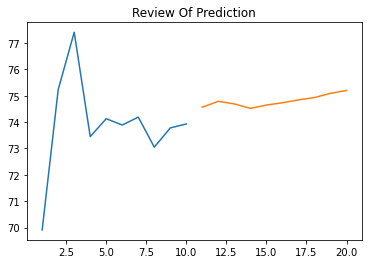

In [35]:
plt.plot(day_new,scaler.inverse_transform(data_oil[8206:]))
plt.title("Review Of Prediction")
plt.plot(day_pred,scaler.inverse_transform(lst_output))
plt.show()

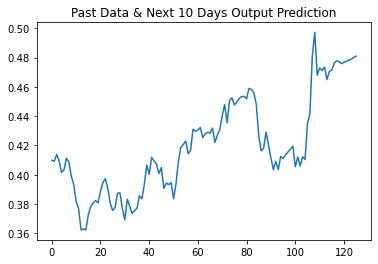

In [36]:
df3 = data_oil.tolist()
df3.extend(lst_output)
plt.title("Past Data & Next 10 Days Output Prediction")
plt.plot(df3[8100:])

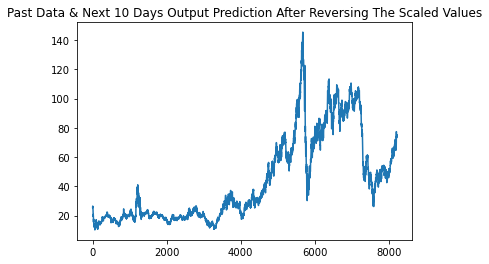

In [37]:
df3 = scaler.inverse_transform(df3).tolist()
plt.title("Past Data & Next 10 Days Output Prediction After Reversing The Scaled Values")
plt.plot(df3)

In [39]:
!pip install ibm_watson_machine_learning

In [27]:
from ibm_watson_machine_learning import APIClient
wml_credentials = {
    "url": "https://us-south.ml.cloud.ibm.com",
    "apikey": "uVEty-CB4dYcccQ_Jq9V-atVXmL1dByE_wiDm95lcyTQ"
}

client = APIClient(wml_credentials)

In [56]:
def guid_from_space_name(client, NewSpace):
    space = client.spaces.get_details()
    return(next(item for item in space['resources'] if item['entity']["name"] == NewSpace)['metadata']['id'])

In [57]:
 space_uid = guid_from_space_name(client, 'NewSpace')
 print("Space UID = " + space_uid)

Space UID = 04546913-9b5c-4add-91ba-df440fc8d6a2


In [34]:
client.set.default_space(space_uid)

'SUCCESS'

In [36]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12      020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9      0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt22.2-py3.10        125b6d9

In [37]:
 software_spec_id =  client.software_specifications.get_id_by_name('tensorflow_rt22.1-py3.9')
 print(software_spec_id)

acd9c798-6974-5d2f-a657-ce06e986df4d


In [54]:
crude_model = Sequential()

In [41]:
ls

Crude_oil.h5  crude-oil-predict-model.tgz


In [46]:
model.save('crude.h5')



In [49]:
ls

crude.h5  Crude_oil.h5  crude-oil-predict-model.tgz  crude-oil.tgz  crude.tgz


In [48]:
!tar -zcvf crude-oil.tgz Crude.h5

tar: Crude.h5: Cannot stat: No such file or directory
tar: Exiting with failure status due to previous errors


In [59]:
software_space_uid = client.software_specifications.get_uid_by_name('tensorflow_rt22.1-py3.9')

In [60]:
software_space_uid

'acd9c798-6974-5d2f-a657-ce06e986df4d'

In [61]:
ls

crude.h5  Crude_oil.h5  crude-oil-predict-model.tgz  crude-oil.tgz  crude.tgz


In [62]:
model_details = client.repository.store_model(model='crude.tgz',meta_props={
client.repository.ModelMetaNames.NAME:"crude_oil_model",
client.repository.ModelMetaNames.TYPE:"tensorflow_2.7",
client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_spec_id }
                                          )
model_id = client.repository.get_model_uid(model_details)

This method is deprecated, please use get_model_id()


/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/ibm_watson_machine_learning/repository.py:1453: UserWarning: This method is deprecated, please use get_model_id()
  warn("This method is deprecated, please use get_model_id()")


In [63]:
model_id = client.repository.get_model_id(model_details)

In [64]:
model_id

'f8ec9f0e-94dd-4bb2-930a-bfe828c596eb'

In [65]:
client.repository.download(model_id,'crude_oil.tar.gb')

Successfully saved model content to file: 'crude_oil.tar.gb'


'/home/wsuser/work/crude_oil.tar.gb'

In [66]:
pwd

'/home/wsuser/work'

In [67]:
client.repository.download(model_id,'crude.tar.gb')

Successfully saved model content to file: 'crude.tar.gb'


'/home/wsuser/work/crude.tar.gb'

In [68]:
client.repository.download(model_id,'crude_oil_model.tar.gb')

Successfully saved model content to file: 'crude_oil_model.tar.gb'


'/home/wsuser/work/crude_oil_model.tar.gb'